!pip install census

!pip install us

In [172]:
from census import Census
from us import states
import pandas as pd
import numpy as np
import pylab as pl
import csv
import matplotlib.pylab
from functools import reduce
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Insert your census api key her below

In [173]:
c = Census("4c26aa6ebbaef54a55d3903212eabbb506ade381")

#### This is the data dictionary

#### 1990 SF3 Variables

#### Creating the buckets for variables that are separeted into bins like income

In [174]:
buckets = [0, 5000, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 32500, 35000, 37500, 40000, 
           42500, 45000, 47500, 50000, 55000, 60000, 75000, 100000, 125000, 150000, 1000000]

#### Insert the variables you want to download.

In [175]:
variables = ['H0040001', 'H0080001', 'H0080002', 'H043A001', 'H061A001', 'P0010001',
             'P0060001', 'P0130018', 'P0130019', 'P0130020', 'P0130021', 'P0130022',
             'P0130023', 'P0130024', 'P0130025', 'P0130026', 'P0130027', 'P0130028',
             'P0130029', 'P0130030', 'P0130031', 'P0570006', 'P0800001', 'P0800002',
             'P0800003', 'P0800004', 'P0800005', 'P0800006', 'P0800007', 'P0800008',
             'P0800009', 'P0800010', 'P0800011', 'P0800012', 'P0800013', 'P0800014',
             'P0800015', 'P0800016', 'P0800017', 'P0800018', 'P0800019', 'P0800020',
             'P0800021', 'P0800022', 'P0800023', 'P0800024', 'P0800025', 'P080A001',
             'P0120002', 'P0080004', 'P0080001', 'P0170003', 'P0420009']

In [176]:
var = variables

In [177]:
for i in range(1,10):
    var.append('P050000'+str(i))
    var.append('P049000'+str(i))
    if i<9:
        var.append('H025000'+str(i))
var.append('P0490010')
var.append('P0490011')
var.append('P0490012')
var.append('P0500010')
var.append('P0500011')
var.append('P0500012')

#### Choose the state and insert its code (as a string number)

In [637]:
state = '36'

In [638]:
sql_query='state:{} county:*'.format(state)

In [639]:
dic = c.sf3.get(var, geo = {'for': 'tract:*',
                       'in': sql_query}, year = 1990)

In [640]:
df = pd.DataFrame.from_dict(dic)

In [641]:
df = df.reset_index()

In [642]:
df = df.drop(columns = 'index')

In [643]:
df['hh_90'] = np.sum(df.iloc[:,59:84],axis=1)
df['pop_over_25'] = np.sum(df.iloc[:,18:32],axis=1)

#### Exporting the raw file

In [644]:
df.to_csv('variables_' + state + '.csv', index = None)

#### Calculating the thresholds for each of the counties

In [645]:
county = df.county.unique()

In [646]:
counties = {}
counties = counties.fromkeys(county)

In [647]:
columns = df.columns

In [648]:
for i in range(0,len(columns)-5):
    df[columns[i]] = df[columns[i]].astype(float)

In [649]:
for i in county:
    counties[i] = np.median(df[df.county == i].P080A001)

In [650]:
df_threshold = pd.DataFrame.from_dict(counties, orient='index')

In [651]:
df_threshold = df_threshold.rename(columns={0:'median'})

In [652]:
#df_typo['vvli_threshold']=0.3*df_typo['median']
df_threshold['vli_threshold'] = 0.5*df_threshold['median']
df_threshold['li_threshold'] = 0.8*df_threshold['median']
df_threshold['mi_threshold'] = 1.2*df_threshold['median']
df_threshold['mhi_threshold'] = 1.5*df_threshold['median']
df_threshold['hi_threshold'] = 2*df_threshold['median']
df_threshold['vhi_threshold'] = 1000000

#### Creating the different typologies based on each county's median income

In [653]:
table = np.zeros((len(county),len(buckets)-1))
for j in range(0, len(counties)):
    col = 1
    for i in range(0, len(buckets)-1):
        if buckets[i+1] < df_threshold.iloc[j, col]:
            table[j, i] = True
        else:
            table[j, i] = (df_threshold.iloc[j, col] - buckets[i]) / (buckets[i+1] - buckets[i])
            col = col+1

In [654]:
values=[]
for i in county:
    with open('variables_'+state+'.csv', 'r') as fi:
        reader = csv.DictReader(fi)
        def creator(reader, c):
            bt = filter(lambda x: x['county'] == c, reader)
            return (list(bt))
        value = creator(reader, i)
    values.append(value)

In [655]:
income_typo = []
for j in range(0, len(county)):
    for i in range(0, len(values[j])):
        typo = []
        summ = 0
        for col in range(0,len(buckets)-1):
            if ((table[j, col] == 1) & (values[j][i]['hh_90']!='0.0')):
                summ = summ + float(values[j][i][var[22+col]])/float(values[j][i]['hh_90'])
            else:
                if values[j][i]['hh_90']!='0.0':
                    summ = summ + float(values[j][i][var[22+col]])*table[j, col]/float(values[j][i]['hh_90'])
                    typo.append(summ)
                    summ = float(values[j][i][var[22+col]])*(1-table[j, col])/float(values[j][i]['hh_90'])
        typo.append(summ)
        income_typo.append(typo)

In [656]:
df_final = pd.DataFrame(income_typo)

In [657]:
df_final = df_final.rename(columns={0:'vli_90', 1:'li_90', 2:'mi_90', 3:'mhi_90', 4:'hi_90', 5:'vhi_90'})

In [658]:
df['commute_low_90'] = df['P0500001']+df['P0500002']+df['P0500003']+df['P0500004']+df['P0500005']+df['P0500006']

In [659]:
df['commute_med_90'] = df['P0500007'] + df['P0500008'] + df['P0500009'] + df['P0500010']

In [660]:
df['commute_high_90'] = df['P0500011'] + df['P0500012']

In [661]:
df['commute_total'] = df['commute_high_90'] + df['commute_med_90'] + df['commute_low_90']

In [662]:
df['transport_total'] = df['P0490002'] + df['P0490003'] + df['P0490004'] + df['P0490005'] + df['P0490006']
df['transport_total'] = df['transport_total'] + df['P0490007'] + df['P0490008'] + df['P0490009'] + df['P0490010'] 
df['transport_total'] = df['transport_total'] + df['P0490011'] + df['P0490012'] + df['P0490001']

In [663]:
df['units_total'] = df['H0250001'] + df['H0250002'] + df['H0250003'] + df['H0250004'] + df['H0250005']
df['units_total'] = df['units_total'] + df['H0250006'] + df['H0250007'] + df['H0250008']
df['units_pre50'] = df['H0250008'] + df['H0250007'] 
df['units_80_90'] = df['H0250001']

In [664]:
moe_names = ['per_col_90', 'per_rent_90', 'per_owners_90', 'per_nonwhite_90','per_black_90', 'per_asian_90', 
             'per_latino_90', 'per_hhwchild_90',  'per_commute_low_90', 'per_commute_med_90', 'per_commute_high_90',
             'per_foreign_90','per_car_commute_90', 'per_units_pre50', 'per_units_post80']

moe_dividend = ['P0570006', 'H0080002', 'H0080001', 'P0060001', 'P0120002', 'P0080004', 'P0080001', 'P0170003',
               'commute_low_90', 'commute_med_90', 'commute_high_90', 'P0420009', 'P0490001', 'units_pre50','H0250001']

moe_divisor = ['pop_over_25', 'H0040001', 'H0040001', 'P0010001', 'P0010001', 'P0010001', 'P0010001', 'hh_90',
              'commute_total', 'commute_total', 'commute_total', 'P0010001','transport_total', 'units_total', 
               'units_total']

In [665]:
for i in range(0,len(moe_names)):
    if i!=3:
        df_final[moe_names[i]] = df[moe_dividend[i]]/df[moe_divisor[i]]
    else:
        df_final[moe_names[i]] = 1 - df[moe_dividend[i]]/df[moe_divisor[i]]

In [666]:
df = df.rename(columns={'H043A001':'mrent_90', 'P080A001':'hinc_90', 
                        'H061A001':'mhval_90', 'H0040001':'hu_90', 'P0010001':'pop_90'})

In [667]:
df_final = df_final.join(df[['hh_90', 'mrent_90', 'hinc_90', 'mhval_90', 'hu_90', 'pop_90', 'state', 'county',
                             'tract']])

#### Droping null values

In [668]:
prev_len = len(df_final)

In [669]:
df_final = df_final.dropna(axis = 0, how = 'any')

In [670]:
final_len = len(df_final)

In [671]:
print('The percentage of information lost is: {}'.format((prev_len-final_len)*100/prev_len))

The percentage of information lost is: 3.0053519967064637


#### Exporting the SF3 1990 final file

In [672]:
df_final['GEOid2'] = df_final['state'] + df_final['county'] + df_final['tract']

In [673]:
df_final['GEOid2'] = df_final.GEOid2.apply(lambda x: str(x))

In [674]:
df_final.to_csv(state+'_1990_variables.csv', index = None)

In [675]:
df_final_len = len(df_final)

#### Interpolating the data to fit 2010 census tract boundaries

In [676]:
df_crosswalk_90 = pd.read_csv('crosswalk_1990_2010.csv')

In [677]:
df_crosswalk_90['state'] = df_crosswalk_90.trtid90.apply(lambda x: str(x)[:2])

In [678]:
df_crosswalk_90_red = df_crosswalk_90[df_crosswalk_90.state==state]

In [679]:
df_crosswalk_90_red = df_crosswalk_90_red.reset_index().drop(columns=['index'])

In [680]:
df_crosswalk_90_red['trtid10'] = df_crosswalk_90_red['trtid10'].apply(lambda x: str(x))
df_crosswalk_90_red['trtid90'] = df_crosswalk_90_red['trtid90'].apply(lambda x: str(x))

In [681]:
id90 = list(df_crosswalk_90_red.trtid90.unique())

In [682]:
id10 = list(df_crosswalk_90_red.trtid10.unique())

#### Cleaning total weight sums that exceeds an stablished threshold

In [683]:
threshold = 0.2

In [688]:
weight_total = 0
for i in id10:
    weight_total = np.sum(df_crosswalk_90_red[df_crosswalk_90_red.trtid10==i].weight)
    if ((weight_total<1-threshold)|(weight_total>1+threshold)):
        id10.remove(i)
        df_crosswalk_90_red = df_crosswalk_90_red[df_crosswalk_90_red.trtid10!=i]
        print(i)

l=[]
for i in range(0,len(df_crosswalk_90_red)):
    l.append(df_crosswalk_90_red['weight'][i]/weight_total[df_crosswalk_90_red.trtid10[i]])

df_crosswalk_90_red['weight'] = l

In [689]:
df_crosswalk_90_red = df_crosswalk_90_red.reset_index().drop(columns='index')

In [690]:
df_final[df_final.GEOid2.isin(id10)].to_csv(state+'_1990_variables_clean.csv', index = None)

In [691]:
tract_id10 = {}
tract_id10 = tract_id10.fromkeys(id10)
for i in range(0, len(df_crosswalk_90_red)):
        if (type(tract_id10[df_crosswalk_90_red['trtid10'][i]])==list):
            tract_id10[df_crosswalk_90_red['trtid10'][i]].append(df_crosswalk_90_red['trtid90'][i])
        if (type(tract_id10[df_crosswalk_90_red['trtid10'][i]])!=list):
            tract_id10[df_crosswalk_90_red['trtid10'][i]] = [df_crosswalk_90_red['trtid90'][i]]

In [692]:
weight_dic = {}
weight_dic = weight_dic.fromkeys(id10)
for i in id10:
    weight_dic[i] = weight_dic.fromkeys(tract_id10[i])

In [693]:
geoid = df_final[df_final.GEOid2.isin(id10)].GEOid2.unique()

In [694]:
for i in range(0,len(df_crosswalk_90_red)):
    try:
        if ((df_crosswalk_90_red['trtid90'][i] in geoid) & (df_crosswalk_90_red['weight'][i]!=0)):
            weight_dic[df_crosswalk_90_red['trtid10'][i]][df_crosswalk_90_red['trtid90'][i]] = df_crosswalk_90_red['weight'][i]
        elif ((len(weight_dic[df_crosswalk_90_red['trtid10'][i]])==1)|(df_crosswalk_90_red['weight'][i]!=0)):
            weight_dic.pop(df_crosswalk_90_red['trtid10'][i])
        else:
            weight_dic[df_crosswalk_90_red['trtid10'][i]].pop(df_crosswalk_90_red['trtid90'][i])
    except:
        pass

In [695]:
def cross(dictionary, reader, key, weight):
    with open(state+'_1990_variables_clean.csv', 'r') as fi:
        reader = csv.DictReader(fi)
        bt = list(filter(lambda x: x['GEOid2'] == key, reader))
        nt = np.fromiter(bt[0].values(), dtype = float)[:-4]*weight
    return (nt)
arr = map(lambda j: reduce((lambda x,y: x+y),(map(lambda k: cross(weight_dic[j], 
                                              reader, k, weight_dic[j][k]), 
                                             list(map(lambda x: x, weight_dic[j]))))), 
                                             list(map(lambda j: j, weight_dic)))

In [696]:
df_final_crosswalk = pd.DataFrame(list(arr), columns = df_final.iloc[:,:-4].columns)

In [697]:
df_final_crosswalk['GEOid2'] = list(map(lambda j: j, weight_dic))

In [698]:
df_final_crosswalk_len = len(df_final_crosswalk)

In [699]:
print('The percentage of information lost is: {}'.format((df_final_len-df_final_crosswalk_len)*100/df_final_len))

The percentage of information lost is: 25.23344651952462


#### Exporting the final file

In [700]:
df_final_crosswalk.to_csv(state+'_1990_variables_crosswalk.csv', index = None)

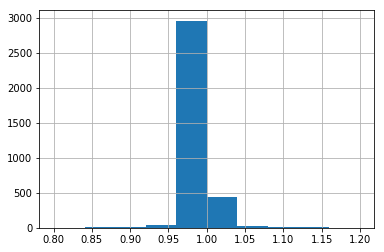

In [701]:
df_final_crosswalk.iloc[:,:6].sum(axis=1).hist()